In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp

### Demand

In [2]:
haushaltgröße = 2 #durchschnittliche Haushaltgröße 2021 https://www.umweltbundesamt.de/daten/private-haushalte-konsum/strukturdaten-privater-haushalte/bevoelkerungsentwicklung-struktur-privater#832-millionen-menschen
stromverbauch_jahr = 3252 #in kWh für 2 personenhaushalt in 2020 https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Umwelt/UGR/private-haushalte/Tabellen/stromverbrauch-haushalte.html
stromverbrauch_tag = stromverbauch_jahr/365
print("Stromverbrauch pro Tag (Durchschnittshaushalt) in kWh: "+str(round(stromverbrauch_tag,4)))

Stromverbrauch pro Tag (Durchschnittshaushalt) in kWh: 8.9096


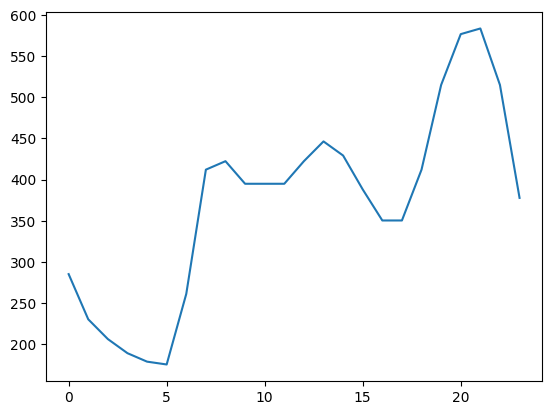

In [28]:
time=np.linspace(0,23,24)

#erstelle konstantes Profil
const_demand = np.ones(24)*stromverbrauch_tag/24

#erstelle realistisches Profil anhand des Verlaufs in https://www.wirtschaftsdienst.eu/inhalt/jahr/2016/heft/4/beitrag/stromersparnis-der-zeitumstellung-bei-privaten-haushalten.html
abgeschrieben_verbrauch=np.array([83,67,60,55,52,51,76,120,123,115,115,115,123,130,125,113,102,102,120,150,168,170,150,110])
abgeschrieben_verbrauch_norm=abgeschrieben_verbrauch/np.sum(abgeschrieben_verbrauch)    #normieren
#plt.plot(time,abgeschrieben_verbrauch)

realist_demand = abgeschrieben_verbrauch_norm*stromverbrauch_tag
plt.plot(time,realist_demand*1000)

### Production

In [30]:
#Production Quelle https://www.eon.de/de/pk/solar/kwp-bedeutung-umrechnung.html
#Produktion im Jahr Durchscnittseinfamilienhaus: 4-10kWp bei 800-1200kWh/kWp Produktion
prod_year_lower = 4*800
prod_year_upper = 10*1200
prod_year = (prod_year_upper+prod_year_lower)/2 #in kWh
prod_day = prod_year/365
print("durchschn. Photovoltaik Produktion pro Tag (Durchschnittshaushalt: Einfamilienhaus) in kWh: "+str(round(prod_day,4)))

durchschn. Photovoltaik Produktion pro Tag (Durchschnittshaushalt: Einfamilienhaus) in kWh: 20.8219


In [39]:
def cosine_squared(x, *par):
    f = par[0]*np.cos(par[1]*(x-par[2]))**2
    return f

In [64]:
def gauß(x, *par):
    f = par[0]*np.exp(-(x-par[1])**2/(2*par[2]**2))
    return f

[2751.77989341   13.50004462    3.0999052 ]
[[ 2.73041368e+03 -3.02440626e-04 -2.05127508e+00]
 [-3.02440626e-04  4.61960154e-03  7.48097938e-07]
 [-2.05127508e+00  7.48097938e-07  4.62183439e-03]]


<ErrorbarContainer object of 3 artists>

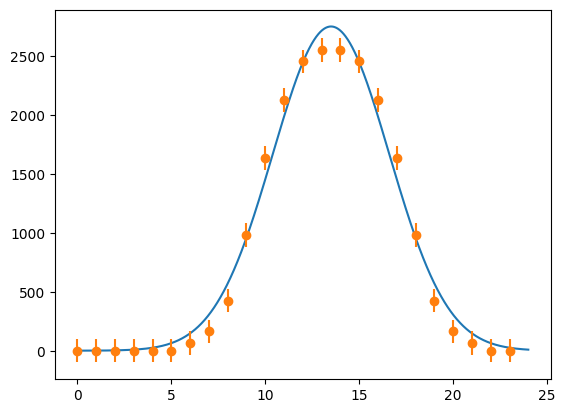

In [79]:
time=np.linspace(0,23,24)

#erstelle konstantes Profil
const_prod = np.ones(24)*prod_day/24

#erstelle realistisches Profil anhand des Verlaufs in https://www.wirtschaftsdienst.eu/inhalt/jahr/2016/heft/4/beitrag/stromersparnis-der-zeitumstellung-bei-privaten-haushalten.html
abgeschrieben_prod=np.array([0,0,0,0,0,0,2,5,13,30,50,65,75,78,78,75,65,50,30,13,5,2,0,0])
abgeschrieben_prod_norm=abgeschrieben_prod/np.sum(abgeschrieben_prod)    #normieren
#plt.plot(time,abgeschrieben_verbrauch)

realist_prod = abgeschrieben_prod_norm*prod_day
par, popt = curve_fit(gauß, time, realist_prod*1000, p0=[2500,13.5,3], sigma=np.ones(24)*100, absolute_sigma=True)
print(par)
print(popt)
x=np.linspace(0,24,1000)
#plt.plot(x, gauß(x, *[2500,13.5,3]))
plt.plot(x,gauß(x,*par))
plt.errorbar(time,realist_prod*1000,yerr=100,linestyle="", marker='o')

### Dataframe erstellen

In [81]:
df = pd.DataFrame(np.transpose(np.array([time,const_demand,const_prod,realist_demand,realist_prod])),
                  columns=['time','constant demand','constant production', 'realistic demand', 'realistic prod'])
#print(df)
df.to_csv('profiles.csv', index=False, header=True)